In [71]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook
import time as t

from scipy.signal import fftconvolve

import sympy

In [158]:
# Grid size and range
grid_size = (100,100)
grid_range = np.array([[-10,10],[-10,10]])
grid_rez = (grid_range[0,1]-grid_range[0,0])/grid_size[0]

# particles
xp = [-2]#,4]
yp = [2]#,-1]
mass = 1.0
G = 1.0
soft = 0.4

# 1D grid for x,y
grid_x = np.linspace( grid_range[0][0] , grid_range[0][1] , grid_size[0])
grid_y = np.linspace( grid_range[1][0] , grid_range[1][1] , grid_size[1])

# 2D grid for x,y
grid_xx , grid_yy = np.meshgrid(grid_x,grid_y)

# 2D kernel 
x_interval = grid_range[0][1]-grid_range[0][0];   y_interval = grid_range[1][1]-grid_range[1][0]
grid_xkern, grid_ykern = np.meshgrid(  np.linspace( -x_interval/2 , x_interval/2 , len(grid_x) )
                               , np.linspace( -y_interval/2 , y_interval/2 , len(grid_y) )  )

<IPython.core.display.Javascript object>


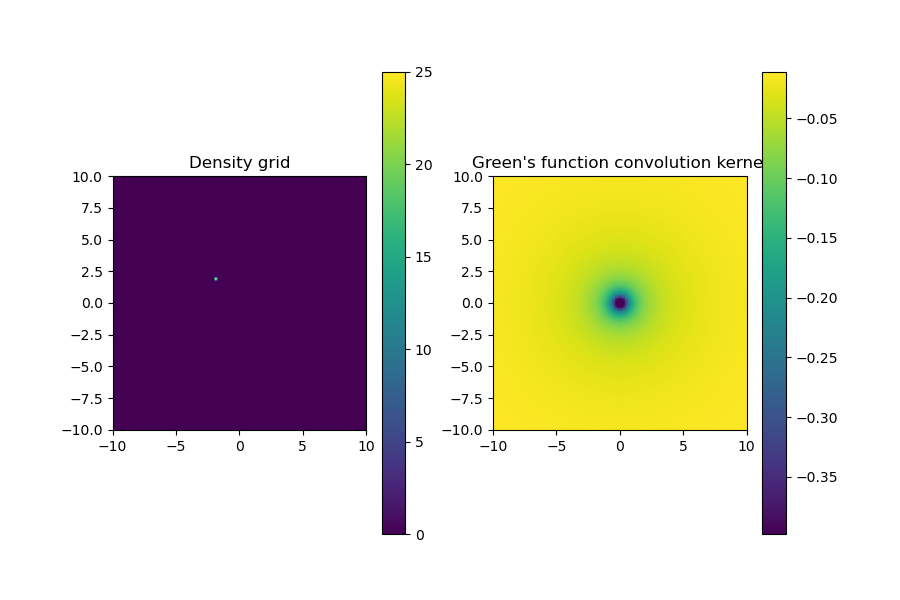

In [159]:
# Create density grid
den2 = np.zeros(grid_size)
indices = []
for i in range(len(xp)):
    xind = (np.abs(xp[i] - grid_x)).argmin()
    yind = (np.abs(yp[i] - grid_y)).argmin()
    den2[xind,yind] += mass/grid_rez**2
    indices.append([xind,yind])

# Create convolution kernel with the Green's function of the laplacian
dist = np.sqrt( grid_xkern**2 + grid_ykern**2 )
#glap = -1*np.log(dist)/(2*np.pi)
#glap = np.where( dist > soft , glap , -1*np.log(dist)/(2*np.pi) )
glap = -1/(2*np.pi*dist)
glap = np.where( dist > soft , glap , -1/(2*np.pi*soft) )

# Show and tell
ext_field = [grid_range[0,0],grid_range[0,1],grid_range[1,0],grid_range[1,1]]
x_interval = grid_range[0,1]-grid_range[0,0];   y_interval = grid_range[1,1]-grid_range[1,0]
ext_kern = [ -x_interval/2,x_interval/2 , -y_interval/2,y_interval/2 ]

plt.figure(figsize=(9,6))
plt.subplot(1,2,1); plt.title('Density grid')
plt.imshow(np.transpose(den2) , origin='lower' , extent=ext_field)
plt.colorbar()
plt.subplot(1,2,2); plt.title("Green's function convolution kernel")
plt.imshow(glap , origin='lower' , extent=ext_kern)
plt.colorbar()

<IPython.core.display.Javascript object>


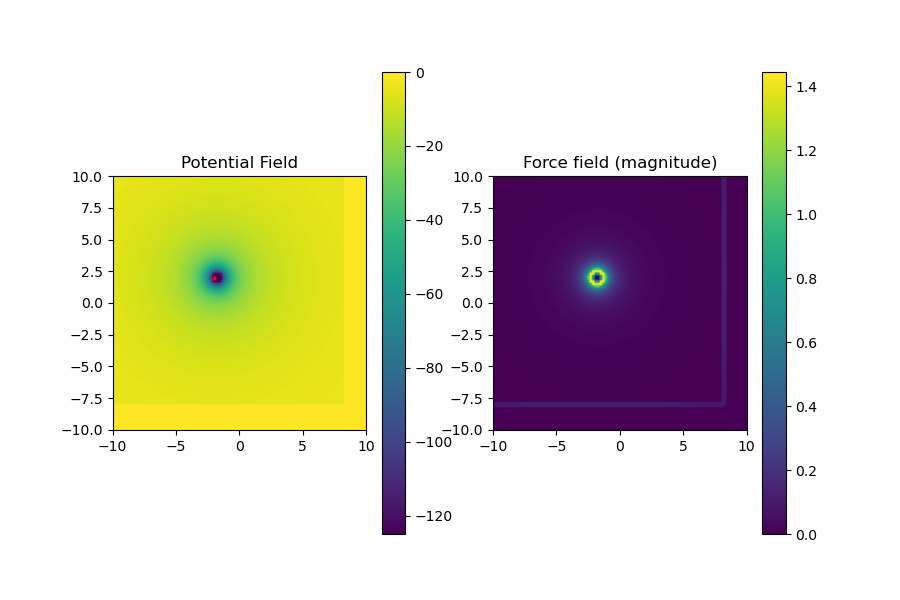

<IPython.core.display.Javascript object>


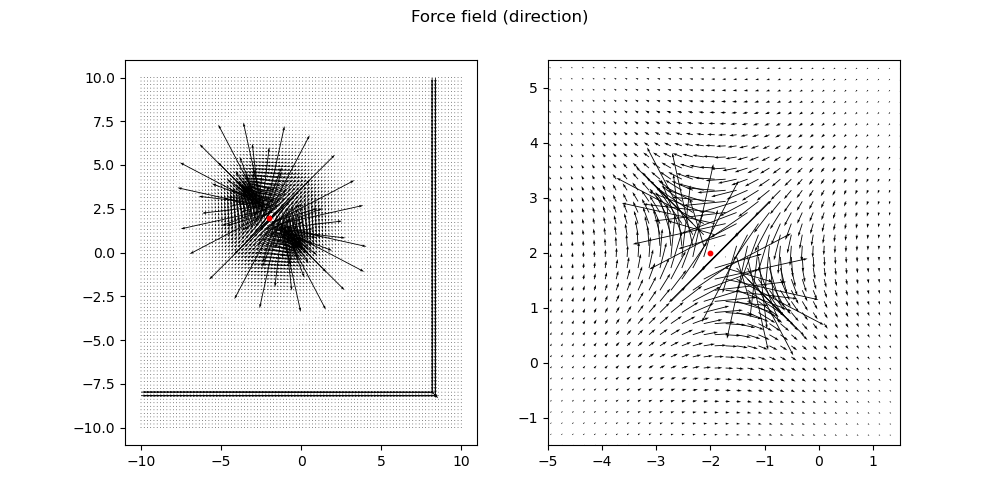

<IPython.core.display.Javascript object>


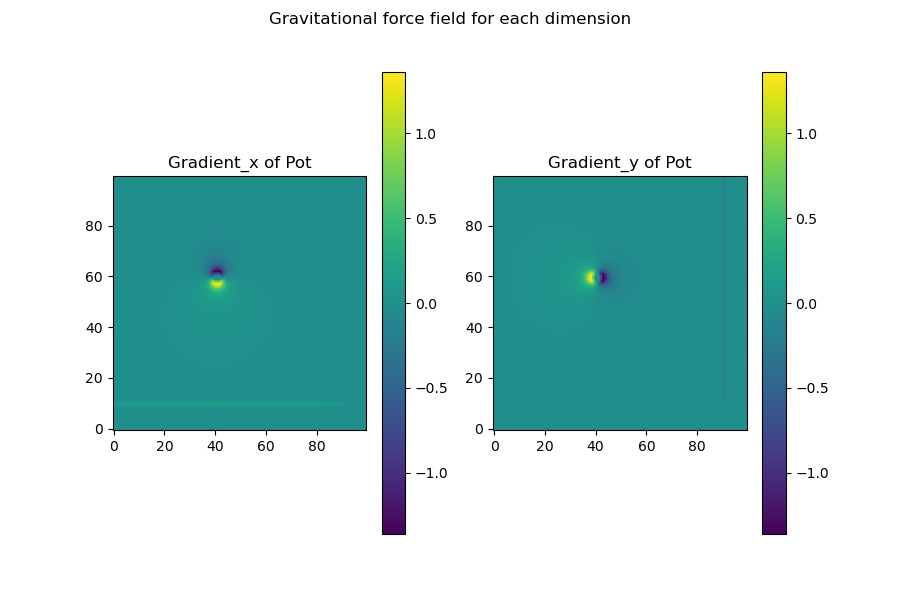

In [166]:
# Calculate the potential
#pot = np.fft.irfftn( np.fft.rfftn(glap) * np.fft.rfftn(den2) )
pot = np.transpose( 4*np.pi*G*fftconvolve(den2,glap , mode='same') )

# Calculate the forces
fx,fy = np.gradient(pot , grid_x , grid_y ) # grid_x, grid_y represent the dx, dy used by np.gradient
fx*=-1/100; fy*=-1/100

# showit
plt.figure(figsize=(9,6))
plt.subplot(1,2,1); plt.title('Potential Field')
plt.imshow(pot , origin='lower' , extent=ext_field)
plt.colorbar()
plt.scatter(xp,yp , s=4,c='r')
plt.subplot(1,2,2); plt.title('Force field (magnitude)')
plt.imshow(np.sqrt(fx**2+fy**2) , origin='lower' , extent=ext_field)
#plt.scatter(xp,yp , s=10,c='r')
plt.colorbar()

plt.figure(figsize=(10,5)); plt.suptitle('Force field (direction)')
plt.subplot(1,2,1)
plt.quiver(grid_xx,grid_yy,fx,fy)
plt.scatter(xp,yp , s=10,c='r')
plt.subplot(1,2,2)
plt.quiver(grid_xx,grid_yy,fx,fy)
plt.scatter(xp,yp , s=10,c='r')
plt.xlim(-5,1.5); plt.ylim(-1.5,5.5)

plt.figure(figsize=(9,6)); plt.suptitle('Gravitational force field for each dimension')
plt.subplot(1,2,1); plt.imshow(fx , origin='lower'); plt.title('Gradient_x of Pot'); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(fy , origin='lower'); plt.title('Gradient_y of Pot'); plt.colorbar()


#grid_xx_rav = grid_xx.ravel(); grid_yy_rav = grid_yy.ravel()
#fx_rav = fx.ravel(); fy_rav = fy.ravel()
#print(len(grid_xx_rav))
#for i in range(len(grid_xx_rav)):
#    plt.arrow( grid_xx_rav[i] , grid_yy_rav[i] , fx_rav[i] , fy_rav[i] )

# What I would like to be getting

<IPython.core.display.Javascript object>


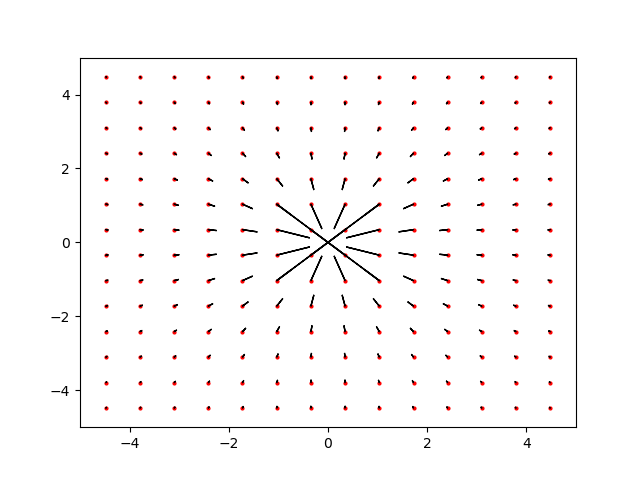

15
17


In [137]:
#define symbolic vars, function
x,y=sympy.symbols('x y')
fun = 1/(x**2 + y**2 + soft**2)**(1/2)

#take the gradient symbolically
gradfun=[sympy.diff(fun,var) for var in (x,y)]

#turn into a bivariate lambda for numpy
numgradfun=sympy.lambdify([x,y],gradfun)

X,Y=np.meshgrid(np.linspace(-10,10,30),np.linspace(-10,10,30))
gradx , grady = np.array(numgradfun(X,Y))

# Setting some points to None to better view the arrows
#X[ int(X.shape[0]/2):int(X.shape[0]/2)+2 , int(X.shape[1]/2):int(X.shape[1]/2)+2 ] = None
#Y[ int(Y.shape[0]/2):int(Y.shape[0]/2)+2 , int(Y.shape[1]/2):int(Y.shape[1]/2)+2 ] = None
#gradx[ int(gradx.shape[0]/2)-1:int(gradx.shape[0]/2)+1 , int(gradx.shape[1]/2)-1:int(gradx.shape[1]/2)+1 ] = None
#grady[ int(grady.shape[0]/2)-1:int(grady.shape[0]/2)+1 , int(grady.shape[1]/2)-1:int(grady.shape[1]/2)+1 ] = None

plt.figure()
#plt.quiver(X,Y,gradx,grady)
for i in range(X.shape[0]):
    for q in range(X.shape[1]):
        plt.arrow( X[i,q] , Y[i,q] , gradx[i,q] , grady[i,q] )
    
plt.scatter(X.ravel(),Y.ravel() , s=4 , c='r')
plt.xlim(-5,5); plt.ylim(-5,5)

print(int(X.shape[0]/2))
print(int(X.shape[0]/2)+2)

# End of demo for TAs

In [89]:
# TRY #2
from sympy import Piecewise, diff, lambdify
from sympy.abc import x,y 

# Create convolution kernel with the Green's function of the laplacian USING SYMPY
glap1 = -1/(2*np.pi*(x**2 + y**2)**(1/2))
glap2 = -1/(2*np.pi*soft)
glap_p = Piecewise( (glap1, (x**2 + y**2)**(1/2) > soft) , (glap2, (x**2 + y**2)**(1/2) <= soft) )

gradfun=[sympy.diff(glap_p,var) for var in (x,y)]

#turn into a bivariate lambda for numpy
numgradfun=sympy.lambdify([x,y],gradfun)

X,Y=np.meshgrid(np.linspace(-10,10,30),np.linspace(-10,10,30))
graddat=np.array(numgradfun(X,Y))

In [ ]:
glap_p.subs(x)

<IPython.core.display.Javascript object>


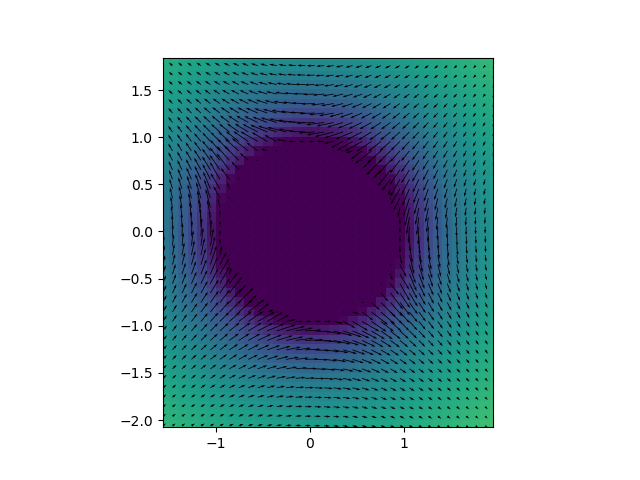

In [70]:
x_interval = grid_range[0][1]-grid_range[0][0];   y_interval = grid_range[1][1]-grid_range[1][0]
grid_xkern, grid_ykern = np.meshgrid(  np.linspace( -x_interval/2 , x_interval/2 , len(grid_x) )
                               , np.linspace( -y_interval/2 , y_interval/2 , len(grid_y) )  )

d = np.sqrt( grid_xkern**2 + grid_ykern**2 )
rekt = -1/d
rekt = np.where( d > 1.0 , rekt , -1/1.0 )
plt.figure()
plt.imshow(rekt , origin='lower' , extent=ext_field)

fx,fy = np.gradient(rekt , np.linspace( -x_interval/2 , x_interval/2 , len(grid_x) )
                         , np.linspace( -y_interval/2 , y_interval/2 , len(grid_y) ) )
fx*=-1/(x_interval/len(grid_x))
fy*=-1/(x_interval/len(grid_x))

plt.quiver(grid_xkern, grid_ykern, fx, fy)
